## Project 1 - Clusters 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

import collections
import queue
import scipy.io as spio

In [2]:
data_input = [i.strip().split() for i in open("./cluster.dat").readlines()]
data_input = pd.DataFrame(data_input)
data_input[0] = pd.to_numeric(data_input[0])
data_input[1] = pd.to_numeric(data_input[1])

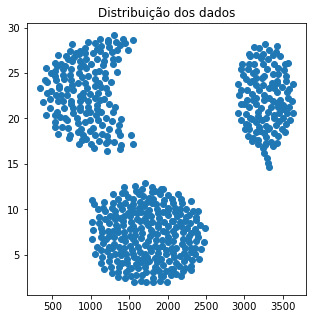

In [3]:
plt.figure(figsize=(5,5))
plt.scatter(data_input[0], data_input[1])
plt.title('Distribuição dos dados')
plt.show()

In [4]:
data_input.describe()

,0,1
count,573.000000,573.000000
mean,1849.808028,15.227836
std,900.129972,8.292268
min,335.000000,1.950000
25%,1155.000000,7.450000
50%,1655.000000,17.200000
75%,2350.000000,22.750000
max,3635.000000,29.150000


In [5]:
def train_test_split(x, train_per = 0.9, test_per = 0.1,shuffle = True):
    
    n_samples = len(x)
    n_train, n_test = round(train_per*n_samples), round(test_per*n_samples)
    
    if shuffle:
        x_teste = x.reindex(np.random.permutation(x.index))
        train = x_teste.iloc[:n_train]
        test = x_teste.iloc[n_train:n_test+n_train]
    else:
        train = x.iloc[:n_train]
        test = x.iloc[n_train:n_test+n_train]
        
    train = train.reset_index(drop=True)
    test = test.reset_index(drop=True)
        
    return train, test

In [6]:
train, test = train_test_split(data_input)

In [7]:
def normalization(x, min_x, max_x):
    return (x - min_x) / (max_x - min_x) 


test[0] = test[0].apply(lambda x: normalization(x, min(train[0]), max(train[0])))
test[1] = test[1].apply(lambda x: normalization(x, min(train[1]), max(train[1])))
train[0] = train[0].apply(lambda x: normalization(x, min(train[0]), max(train[0])))
train[1] = train[1].apply(lambda x: normalization(x, min(train[1]), max(train[1])))

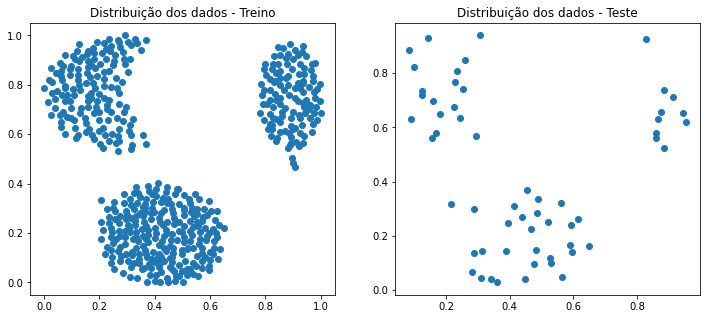

In [8]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.scatter(train[0], train[1])
plt.title('Distribuição dos dados - Treino')


plt.subplot(1,2,2)
plt.scatter(test[0], test[1])
plt.title('Distribuição dos dados - Teste')
plt.show()

In [9]:
class Mean_Shift:
    def __init__(self, radius=4):
        self.radius = radius

    def fit(self, data):
        data = np.array(data)
        centroids = {}

        for i in range(len(data)):
            centroids[i] = data[i]
        
        while True:
            new_centroids = []
            for i in centroids:
                in_bandwidth = []
                centroid = centroids[i]
                for featureset in data:
                    if np.linalg.norm(featureset-centroid) < self.radius:
                        in_bandwidth.append(featureset)

                new_centroid = np.average(in_bandwidth,axis=0)
                new_centroids.append(tuple(new_centroid))

            uniques = sorted(list(set(new_centroids)))

            prev_centroids = dict(centroids)

            centroids = {}
            for i in range(len(uniques)):
                centroids[i] = np.array(uniques[i])

            optimized = True

            for i in centroids:
                if not np.array_equal(centroids[i], prev_centroids[i]):
                    optimized = False
                if not optimized:
                    break
                
            if optimized:
                break

        self.centroids = centroids
        
    def euclidean_distance(self, x, centroid):
        return (x[0]-centroid[0])**2 + (x[1]-centroid[1])**2
        
        
    def predict(self, data):
        data = np.array(data)
        label = []
        for i in data:
            min_distance = float('inf')
            for centroid in self.centroids:
                distance = self.euclidean_distance(i, self.centroids[centroid])
                
                if distance < min_distance:
                    label_centroid = centroid
                    min_distance = distance
            
            label.append(label_centroid)
            
        return label

In [10]:
import pandas as pd 

clf = Mean_Shift(radius = 0.3)
clf.fit(train)

In [11]:
centroids = clf.centroids

In [12]:
centroids


{0: array([0.18184809, 0.77677535]),
 1: array([0.42346001, 0.19320305]),
 2: array([0.88958333, 0.74462316])}

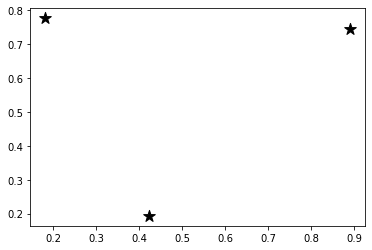

In [13]:
for c in centroids:
    plt.scatter(centroids[c][0], centroids[c][1], color='k', marker='*', s=150)

plt.show()

In [14]:
train['label'] = clf.predict(train)
test['label'] = clf.predict(test)

In [15]:
train = train.rename({0: 'x', 1: 'y'}, axis=1) 
test = test.rename({0: 'x', 1: 'y'}, axis =1 )

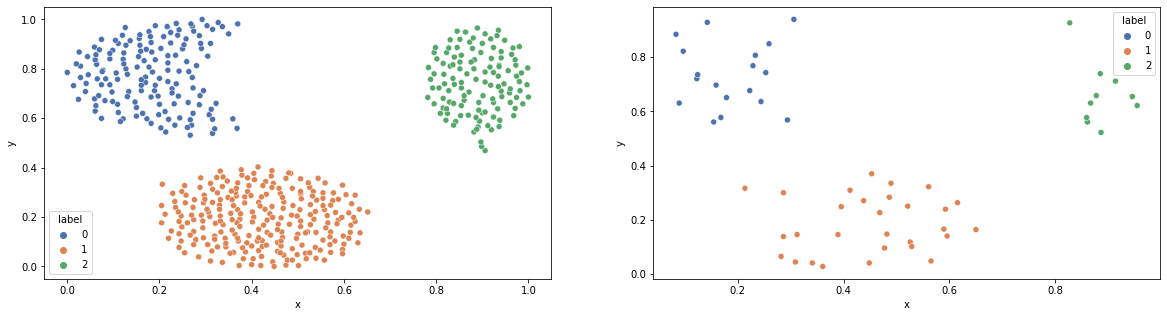

In [16]:
import seaborn as sns

plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
sns.scatterplot(data=train, x="x", y="y", hue="label", palette="deep")

plt.subplot(1,2,2) 
sns.scatterplot(data=test, x="x", y="y", hue="label", palette="deep") 
plt.show()
